In [1]:
import numpy as np
import json
import os
import matplotlib.pyplot as plt

In [2]:
# load mask labelled points
labelled_points = np.load("mask.npz")["arm_keypoints"]

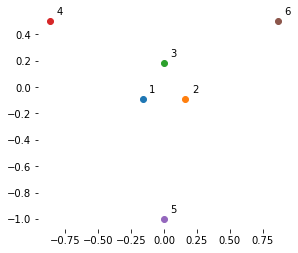

In [3]:
def euclidean_distance(point1, point2):
    """
    Calculate the euclidean distance between two points
    """
    return np.linalg.norm(point1 - point2)

arm_length = 1.0
arm_width = arm_length * np.mean([np.mean([
    euclidean_distance(labelled_points[i][0],labelled_points[i][1]),
    euclidean_distance(labelled_points[i][1],labelled_points[i][2]),
    euclidean_distance(labelled_points[i][2],labelled_points[i][0])
]) / np.mean([
    euclidean_distance(labelled_points[i][3],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][4],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3),
    euclidean_distance(labelled_points[i][5],(labelled_points[i][0]+labelled_points[i][1]+labelled_points[i][2])/3)
]) for i in range(len(labelled_points))])

reward_distance = 0.8
origin = np.array([0.0, 0.0])

# get three corners of a triangle
k1 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+2*np.pi/3), np.sin(np.pi/2+2*np.pi/3)])
k2 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2+4*np.pi/3), np.sin(np.pi/2+4*np.pi/3)])
k3 = origin + arm_width/np.sqrt(3) * np.array([np.cos(np.pi/2), np.sin(np.pi/2)])

# get the endpoints of the arm
k4 = origin + arm_length * np.array([np.cos(np.pi/6+2*np.pi/3), np.sin(np.pi/6+2*np.pi/3)])
k5 = origin + arm_length * np.array([np.cos(np.pi/6+4*np.pi/3), np.sin(np.pi/6+4*np.pi/3)])
k6 = origin + arm_length * np.array([np.cos(np.pi/6), np.sin(np.pi/6)])

# plot the triangles
for i,k in enumerate([k1, k2, k3, k4, k5, k6]):
    plt.plot(k[0], k[1], 'o')
    plt.text(k[0] + 0.05, k[1] + 0.05, str(i+1))

plt.gca().set_aspect('equal')
plt.box()
plt.show()

reference_points = np.array([k1, k2, k3, k4, k5, k6])

In [4]:
from skimage.transform import estimate_transform, AffineTransform

estimated_transforms = []
for i in range(len(labelled_points)):
    # get the points
    points = labelled_points[i]
    # get the affine transform
    transform = estimate_transform("affine", points, reference_points)
    # add to the list
    estimated_transforms.append(transform)

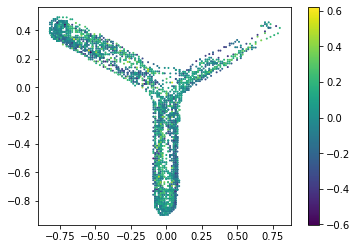

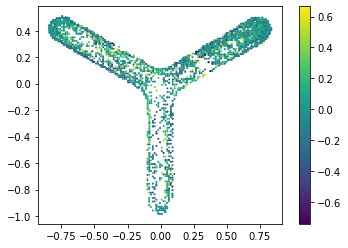

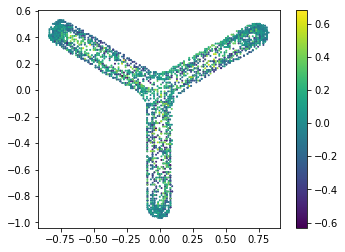

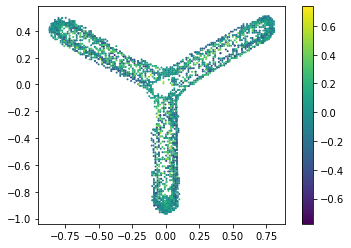

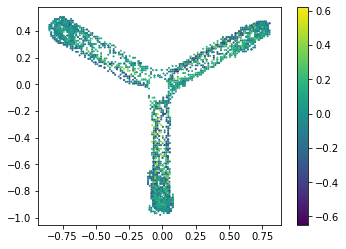

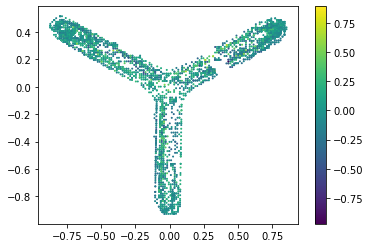

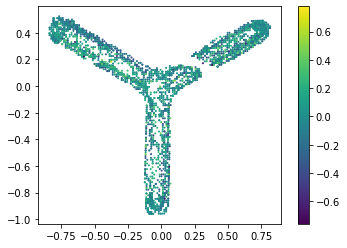

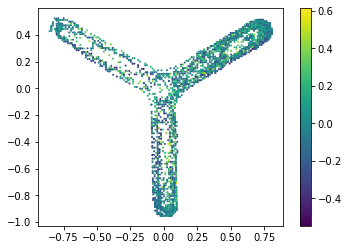

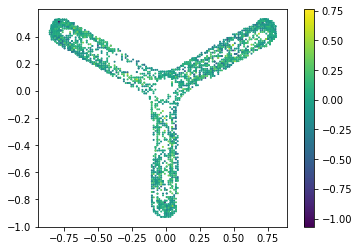

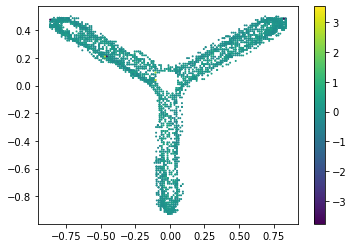

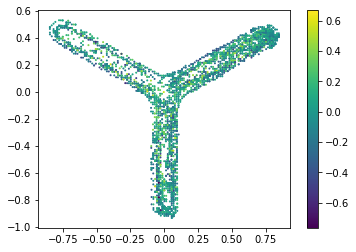

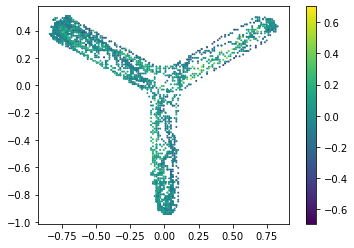

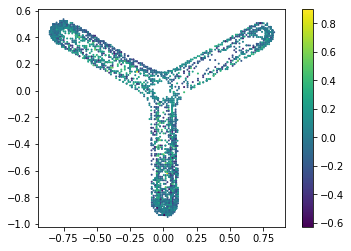

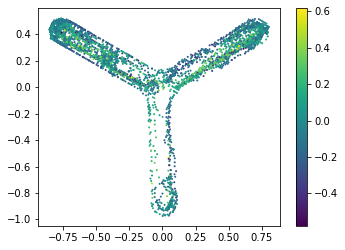

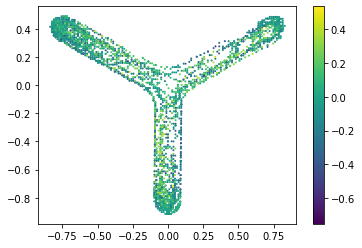

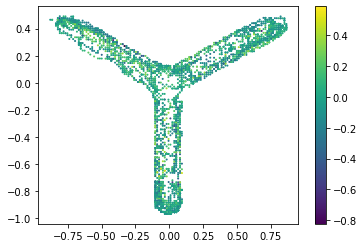

In [21]:
for i in os.listdir("data"):
    if i.endswith(".ydata"):
        with open("data/" + i, "r") as f:
            data = json.load(f)
        # get index of the arena
        index = int(i.split(".")[0].split("_")[-1])
        # get fly position
        fly_position = np.array(data['fly_positions'])
        # switch x and y
        fly_position = fly_position[:, [1, 0]]
        # get the estimated transform
        transform = estimated_transforms[index]
        # add the transformed fly position
        reference_fly_positions = transform(fly_position)
        # calculate instantaneous speed
        speed = np.linalg.norm(np.diff(reference_fly_positions, axis=0),axis=1)/np.diff(data['frame_times'], axis=0)
        # calculate instantaneous heading
        heading = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0))
        # calculate upwind speed
        radial_distance = np.linalg.norm(reference_fly_positions-origin, axis=1)
        upwind_speed = np.diff(radial_distance, axis=0)/np.diff(data['frame_times'], axis=0)
        # calculate upwind orientation
        upwind_orientation = np.arctan2(np.diff(reference_fly_positions[:, 1], axis=0), np.diff(reference_fly_positions[:, 0], axis=0)) - \
                            np.arctan2 (reference_fly_positions[:-1,1]-origin[1], reference_fly_positions[:-1,0]-origin[0])
        # plot the transformed fly position colored by upwind speed
        plt.scatter(reference_fly_positions[:-1, 0], reference_fly_positions[:-1, 1], c=upwind_speed, s=1)
        plt.colorbar()
        plt.gca().set_aspect('equal')
        plt.show()